<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/3A_Stack_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Last amended: 6th June, 2021
Kaggle: https://www.kaggle.com/c/tabular-playground-series-may-2021/overview

Objectives:
           Optimizing wts of multiple classifiers
           This technique works well when number of classes
           to be predicted in the label/target column are
           more.


""" 

##Call libraries


In [ ]:
# 1.0 Clear memory
#%reset -f

# 1.1 Call data manipulation libraries
import numpy as np

# 1.2 Data generation
from sklearn.datasets import make_classification

# 1.3 Feature creation Classes
from sklearn.preprocessing import PolynomialFeatures  

# 1.3.1 BoxCox transformations:
from sklearn.preprocessing import PowerTransformer  

# 1.4 For feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFpr
from sklearn.feature_selection import mutual_info_classif, chi2,f_classif
from sklearn.feature_selection import  VarianceThreshold 


# 1.4.1 Scaling data 
from sklearn.preprocessing import StandardScaler


# 1.5 Splitting data
from sklearn.model_selection import train_test_split     


# 1.6 Pipelines
from sklearn.pipeline import make_pipeline

# 1.7 Modeling
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

# 1.8 Performance metrics
from sklearn.metrics import  log_loss

# 1.9 scipy optimize
from scipy.optimize import minimize

In [ ]:
# 1.10 Display multiple commands output from a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Feature Selection using SelectKBest()

Reference this [link](https://stats.stackexchange.com/a/253686)

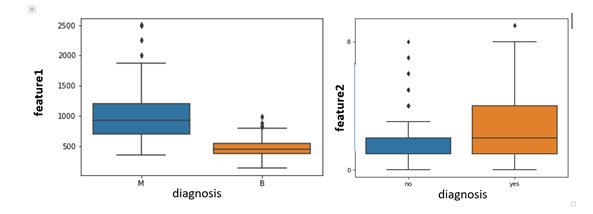

Which of the above two features is better in correct diagnosis: feature1 or feature2? Formally we calculate an F-statistic. `F-test` determines whether group means are equal, or significantly different. The more the difference, higher the value of F-statistic. F-statistic is formally defined as,<br>
`
F = (variation between sample means) / (variation within each of the samples)
`
<br>
If the sample means are not significantly different then the value will be 1. For a more formal definition, please see [Wikipedia](https://en.wikipedia.org/wiki/F-test#Multiple-comparison_ANOVA_problems).

Two examples. One with low F value another with high F-value.<br>

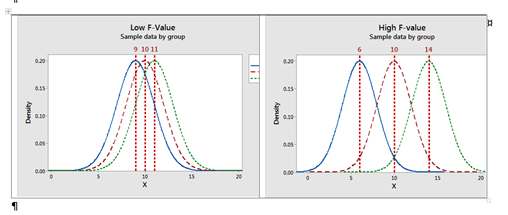

A caveat<br>
There is a caveat to above arguments. Importance of F-statistic is true only when some rather stringent conditions are met: for example, each feature must come from normally distributed populations, and the population variance of the K groups (where K is number of classes) must be the same. This may not hold in practice, and without this assumption the F-values are meaningless. 

Default scoring function of `SelectKBest()` is `f_classif`. [f_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif) uses F-statistic as a scoring mechanism. Another scoring function is [chi2](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2). 

Pearson's chi-squared test is used to determine whether there is a statistically significant difference between the expected frequencies and the observed frequencies in one or more categories of a contingency table. In this case we try to find independence of target feature with each one of the other features in the dataset. For example, in the following case, there is a definite relationship between <i>'Rooms'</i> and the colour (<i>Blue</i> or <i>Red</i>).

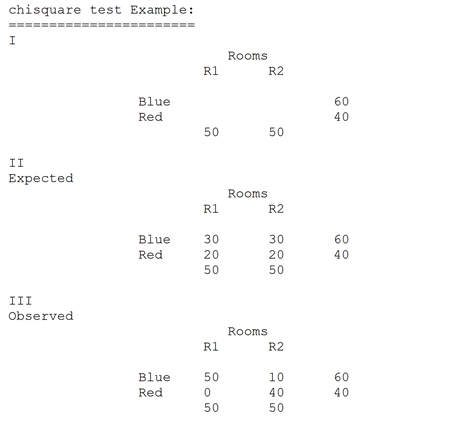

Here is how the statistic calculated:

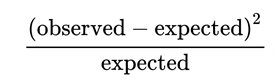

## Generate data

In [ ]:
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html
# 2.0
X,y = make_classification(
                          n_samples=10000,
                          n_features=30,
                          n_informative=25, 
                          n_redundant=5,
                          n_repeated=0,
                          n_classes=11,
                          class_sep=0.6,
                          flip_y=0.1,
                          )

# 2.1 
X.shape            # (10000, 30)

(10000, 30)

In [ ]:
# 2.2 About target values and distribution:

np.unique(y)
print()
np.bincount(y)  # Almost balanced

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

array([918, 893, 902, 914, 929, 911, 890, 917, 900, 913, 913])

In [ ]:
# 2.3 Perform stratified sampling:

X_train, X_test, y_train,y_test = train_test_split(
                                                   X,
                                                   y,
                                                   test_size = 0.3,
                                                   stratify = y,
                                                   shuffle= True)

# 2.4:
X_train.shape  # (7000, 30)
X_test.shape   # (3000, 30)

(7000, 30)

(3000, 30)

## Create different pipes

### pipe1

In [ ]:
# 3.0 Our first pipe:
pipe1 = make_pipeline(
                      StandardScaler(),       # pipe1[0] Try other Scalers also
                      rf(                     # pipe1[1]
                          n_estimators=100,
                          max_depth = 20
                        )
                      )

In [ ]:
# 3.1 Train pipe1
pipe1.fit(X_train,y_train)

# 3.2 Make probability predictions:
prob_pipe1 = pipe1.predict_proba(X_test)

# 3.3 Probability shape
print()
prob_pipe1.shape   # (3000, 11)

# 3.4 Logloss for pipe1
print()
log_loss(y_test,prob_pipe1)         # 1.6656872360747987

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=20, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=Fal

(3000, 11)

1.937303127414795

### pipe2
Uses `PowerTransformer()`

In [ ]:
# 4.0 Instantiate pipe
#     PowerTransform() data
pipe2 = make_pipeline(
                      StandardScaler(),
                      PowerTransformer(),
                      rf(                    
                          n_estimators=100,
                          max_depth = 30
                         )
                       )

# 4.1 Train pipe2 and determine logloss:
pipe2.fit(X_train,y_train)
prob_pipe2 = pipe2.predict_proba(X_test)
print()
prob_pipe2.shape             # (3000,11)
print()
log_loss(y_test,prob_pipe2)  # 1.6770240488569925

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('powertransformer',
                 PowerTransformer(copy=True, method='yeo-johnson',
                                  standardize=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=30, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
          

(3000, 11)

1.9552591009105458

### pipe3
Uses ExtraTreesClassifier

In [ ]:
# 5.0 Instantiation
pipe3 = make_pipeline(
                       StandardScaler(),
                       ExtraTreesClassifier(n_estimators=300)
                      )

# 5.1 Train pipe and determine logloss
pipe3.fit(X_train,y_train)
prob_pipe3 = pipe3.predict_proba(X_test)
print()
log_loss(y_test,prob_pipe3)         # 1.6787868142300655

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('extratreesclassifier',
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, max_features='auto',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=300, n_jobs=None,
                                      oob_score=False, random_state=None,
                                      verbose=0, warm_start=False))],
         verbose=False)

1.9317427211350047

### pipe4

Experiment here with different data transformations

In [ ]:
# 6.1
# Another pipe:

pipe4 = make_pipeline(
                      StandardScaler(),
                      PolynomialFeatures(
                                         degree =2,
                                         interaction_only=False
                                         ),
                      
                      VarianceThreshold(
                                         threshold=0.3
                                        ),
                      
                      SelectKBest(
                                   score_func= f_classif,
                                   k=100
                                  ),
                      # SelectFpr() ,  
                      rf(                    
                          n_estimators=100,
                          max_depth = 35,
                         )
                       )

# 6.2
pipe4.fit(X_train,y_train)
prob_pipe4 = pipe4.predict_proba(X_test)
prob_pipe4.shape     # (3000, 11)
print()
log_loss(y_test,prob_pipe4)  # 1.7974766564233063

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('variancethreshold', VarianceThreshold(threshold=0.3)),
                ('selectkbest',
                 SelectKBest(k=100,
                             score_func=<function f_classif at 0x7f0761c4e560>)),
                ('random...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=35, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
     

(3000, 11)

2.076875733860783

### pipe5
Use LogisticRegression()

In [ ]:
# 7.0
# Use another Estimator: LogisticRegression()

pipe5 = make_pipeline(
                      StandardScaler(),
                      LogisticRegression(
                                         max_iter = 8000,
                                         ),
                      )


# 7.1 How much is logloss
pipe5.fit(X_train,y_train)
prob_pipe5 = pipe5.predict_proba(X_test)
prob_pipe5.shape   # (18564, 11)

print()
log_loss(y_test,prob_pipe5)    # 1.9415628390694406

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=8000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

(3000, 11)

2.2108555902286033

## Perform optimization
Average probabilties through optimization.
Calculate weighted average of probabilities to make final probability predictions.

### How it works?
You have to assign importance-wt to each classifier. Mulitply the probabilities of each classifier with respetive wts and add up probabilities (class-wise).

```
Once you have calculated probability predictions
of the nine classes through different models, you 
can add up probabilities of models in a weighted
manner to determine final probabilities and logloss.
Here is an example.

Let us say there are three classes. Here are the
probability predictions for one observation of test
set from three different models:

class1     class2       class3
0.2        0.4           0.4   =>       Model1
0.6        0.2           0.2   =>       Model2
0.1        0.7           0.2   =>       Model3

Final probability predictions for the three classes
are then calculated, as:

class1:   w1 * 0.2   + w2 * 0.6  +  w3 * 0.1
class2:   w1 * 0.4   + w2 * 0,2  +  w3 * 0.2
class3:   w1 * 0.4   + w2 * 0.2  +  w3 * 0.2

Let us say, for some initial w1,w2,w3 the three
probabilities from Ist test obs form an array of 
three values, prob_class[0,3]. For second, obs 
using the same set of weights, we get a similar 
array, prob_class[1,3] and so on. 

We then calculate overall log_loss (ie error), as:

         log_loss(y_test, prob_class)
         where both y_test and prob_class
         have shape: (n_test_samples,3)

scipy optimize module then tries to move w1, w2 and w3 in
the direction such that next calculation of error (log_loss)
gives (hopefully) better results.

```

### Explaining scipy optimization
Refer [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) and [here](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html)

To use scipy optimize module, we have to clearly specify objective, constraints and bounds of variables. (Equality constraint means that the constraint function result is to be zero whereas inequality means that it is to be non-negative. )

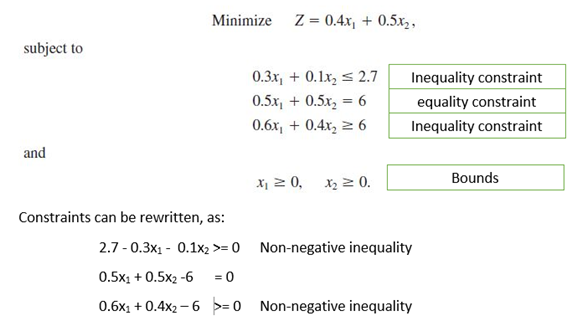

In [ ]:
# 8.0 This video explains scipy optimization process
#      in a very easy manner:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/cXHvC_FGx24?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

#### Collect our pipes in one list

In [ ]:
# 8.1
# Create a list of all pipes:

clfs = []
clfs.append(pipe1)
clfs.append(pipe2)
clfs.append(pipe3)
clfs.append(pipe4)
clfs.append(pipe5)

##### Then use these pipes to make predictions on X_test
Our X_test has 3000 observations. So each pipe will output an array of predictions of shape (3000,9). Thus, we will have a list of five elements. Each element is an array of shape (3000,9).




##### Make probability predictions

In [ ]:
# 8.2
# Make a list of all predictions:
predictions = []
for clf in clfs:
    predictions.append(clf.predict_proba(X_test))

# 8.3
print("\n--Predictions from how many models?---\n")
len(predictions)   # 5 

# 8.4 
print("\n\n--Shape of each prediction array--\n")
predictions[0].shape   # (3000,11)

# 8.5
print("\n\n--First three rows of predictions from pipe1--\n")
np.round(predictions[0][:3,:],3)   


--Predictions from how many models?---



5



--Shape of each prediction array--



(3000, 11)



--First three rows of predictions from pipe1--



array([[0.048, 0.022, 0.17 , 0.069, 0.054, 0.117, 0.058, 0.13 , 0.041,
        0.248, 0.044],
       [0.042, 0.073, 0.122, 0.102, 0.133, 0.042, 0.062, 0.082, 0.154,
        0.072, 0.113],
       [0.12 , 0.   , 0.197, 0.122, 0.14 , 0.041, 0.071, 0.047, 0.063,
        0.061, 0.138]])

### Formulate optimization objective and constraints
Our objective is simple. Add up probabilities in a manner so as to minimize log-loss.</br>
Our constraint is that each wt to be multipled by a pipe's prediction should be between (0,1) and some of all wts should be 1.



We have to specify: 
> Repeat the following multiple times to make sure we are not stuck at some local optima
>> Loop a to d to determine optimimum wts
>>> a. Objective function<br>
>>> b. Define constraints on weights<br>
>>> c. Define bounds on weights<br>
>>> d. Some initial wt values<br>




logloss vs wt. Avoid being stuck ate local minimum


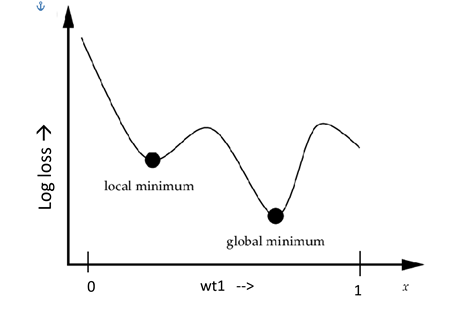

#### Objective function

In [ ]:
## 9.0 Objective function:

def objective_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    final_prediction = 0
    # We have five wts and five predictions
    for weight, prediction in zip(weights, predictions):
            final_prediction += weight*prediction

    return log_loss(y_test, final_prediction)

In [ ]:
# 9.1 This is what happens within objective function:

final_prediction = 0
wts = [0.1,0.2,0.3]
preds = [ np.array([2,5,4]),
          np.array([3,6,9]),
          np.array([1,2,3])
          ]
for weight, prediction in zip(wts, preds):
  print(weight)
  print(prediction)
  print(weight * prediction)
  print("\n---------------\n")
  final_prediction += weight*prediction
  print(final_prediction)
  print(type(final_prediction))
  print("\n================\n")



0.1
[2 5 4]
[0.2 0.5 0.4]

---------------

[0.2 0.5 0.4]
<class 'numpy.ndarray'>


0.2
[3 6 9]
[0.6 1.2 1.8]

---------------

[0.8 1.7 2.2]
<class 'numpy.ndarray'>


0.3
[1 2 3]
[0.3 0.6 0.9]

---------------

[1.1 2.3 3.1]
<class 'numpy.ndarray'>




#### Constraints

In [ ]:
# 10.0
# Define contraint

# Following means return value of const_f() must equal 0

cons = (
         {'type':'eq',     # It is an 'equality' constraint
          'fun': const_f   # Return value of this function
                           # should be 0
         }
       )

In [ ]:
## 10.1 Contrsaint function:

# One constraint is sum of all weights
#  should be one. That is:
#   np.sum(w) = 1
#    OR np.sum(w) - 1 = 0
#     Define a function accordingly:

def const_f(weights):
  ''' scipy minimize will pass the weights as a numpy array '''
  return np.sum(weights) -1  


##### Other types of constraint definitions

In [ ]:
# 10.1.2 
# Following means output of const_f must be greater than 0
# ie np.sum(weights) -1  >= 0
# Or np.sum(weights) >= 1 

cons1 = (
         {'type':'ineq',     # Inequality constraint
          'fun': const_f   
         }
       )

In [ ]:
# 10.1.3
# Following means output of const_f must be less than 0
# ie 1 - np.sum(weights) >= 0
# Or np.sum(weights) <= 1 


def const_x(weights):
  ''' scipy minimize will pass the weights as a numpy array '''
  return 1- np.sum(weights)  

cons2 = (
         {'type':'ineq',     # Inequality constraint
          'fun': const_x   
         }
       ) 


#### Bounds

In [ ]:
## 11.0 Bounds on weight-values:
#       Our weights are bound between 0 and 1

bounds = [(0,1)]*len(predictions)
bounds

[(0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

#### Starting wt values

In [ ]:
## 12.1 Initial wt values

# The algorithm needs some starting wt-values. 
# We select randomly even though sum of these wts
#  is not one:
# 
# Generally, it is better to select many random starting
#  points and run minimize a few times to see which one of the 
#   wt combinations gives best results:

starting_wt_values = np.random.rand(len(predictions))
starting_wt_values

array([0.33069275, 0.15609036, 0.01582774, 0.38552953, 0.89067703])

### Finally optimize

In [ ]:
# help(minimize)

In [ ]:
## 13 Begin optimization process:

res = minimize(
                  fun=objective_func,   # Minimize logloss
                  constraints=cons,     # Our dictionary
                  bounds=bounds,        # Limits of wt values

                  x0 =starting_wt_values,
                  method='SLSQP',
               )

In [ ]:
# 13.1 
# What is the best log loss value

res['fun']


1.9191440469407952

In [ ]:
# 13.2 And what were the best set of wts that made this possible:

res['x']


array([3.78426367e-01, 2.64678743e-01, 3.56894890e-01, 3.81639165e-17,
       0.00000000e+00])

In [ ]:
############## I am done #################